# 股价预测专题

In [175]:
# 必要的库
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler  # 进行归一化操作


## 数据准备

### 参数区

In [176]:
# 特征工程和数据集
factor_column = ['close', 'img_neg', 'tex_neg', 'SENT_INDEX', 'SENT_INDEX_R']
# factor_column = ['close']
df_data = pd.read_csv('../DataSets/IS-TimeSeries.csv', usecols=factor_column)
df_data = df_data[factor_column]  #第一个是标签
# 参数区
TIME_STEPS = 4  # 时间窗
FORECAST_STEPS = 2  # 未来步长
BATCH_SIZE = 1024
EPOCHS = 100
FEATURES = len(factor_column)  # 特征
train_size, val_size = int(len(df_data) * 0.6), int(len(df_data) * 0.8)  #训练集,测试集


In [177]:
df_data

,close,img_neg,tex_neg,SENT_INDEX,SENT_INDEX_R
0,2900.6300,0.000000,0.000000,-0.932715,-1.191905
1,2874.3200,0.000000,0.333333,-0.928031,-1.182604
2,2803.2900,0.285714,0.142857,-0.917702,-1.175354
3,2814.1000,0.000000,0.333333,-0.914326,-1.172984
4,2825.8200,0.333333,0.000000,-0.931606,-1.185114
...,...,...,...,...,...
1939,5897.1579,0.220339,0.152542,0.597233,0.390557
1940,5939.4153,0.047619,0.238095,1.426782,1.186737
1941,5885.3073,0.250000,0.350000,0.202870,0.013389
1942,5935.2719,0.388889,0.277778,1.203630,0.972127


### 数据集转换

In [178]:
# 归一化 将数据缩放到 [0, 1] 范围内
Scaler = MinMaxScaler()
df_std = Scaler.fit_transform(df_data)

# 将数据集分为训练集,验证集和测试集
train_data, val_data, test_data = df_std[0:train_size, :], df_std[train_size:val_size, :], df_std[val_size:, :]


# 将时间序列数据转换为监督学习数据
def create_dataset(dataset, look_back=TIME_STEPS, forecast=FORECAST_STEPS):
    x, y = [], []
    for i in range(len(dataset) - look_back - forecast + 1):
        x.append(dataset[i:(i + look_back), :])  # 已经包含了过去的数据
        y.append(dataset[(i + look_back):(i + look_back + forecast), 0])  #第一个是标签,标签延后了一天
    return np.array(x), np.array(y)


# 生成训练集和测试集
train_X, train_Y = create_dataset(train_data, TIME_STEPS)
val_X, val_Y = create_dataset(val_data, TIME_STEPS)
test_X, test_Y = create_dataset(test_data, TIME_STEPS)
test_X.shape, test_Y.shape,  # [样本数, 时间步数, 特征数]

((384, 4, 5), (384, 2))

## 模型构建

In [179]:
# 构建LSTM模型
model = Sequential([
        LSTM(units=64, input_shape=(TIME_STEPS, FEATURES), return_sequences=True),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64, return_sequences=True),
        Dropout(0.2),
        LSTM(units=64),
        Dropout(0.2),
        Dense(units=FORECAST_STEPS, activation='sigmoid')  #预测步长
])

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#binary_crossentropy
model.summary()

2023-06-16 15:53:02.981855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 15:53:02.982453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 15:53:02.982974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 4, 64)             17920     
                                                                 
 dropout_40 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_41 (LSTM)              (None, 4, 64)             33024     
                                                                 
 dropout_41 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_42 (LSTM)              (None, 4, 64)             33024     
                                                                 
 dropout_42 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_43 (LSTM)              (None, 64)              

2023-06-16 15:53:03.208112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 15:53:03.209200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 15:53:03.210316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## 模型训练

In [180]:
# 训练模型
history = model.fit(train_X, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_X, val_Y), verbose=2)

Epoch 1/100


2023-06-16 15:53:03.449073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 15:53:03.449922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 15:53:03.450473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 - 3s - loss: 0.6929 - accuracy: 0.4479 - val_loss: 0.6893 - val_accuracy: 0.4792 - 3s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 0.6903 - accuracy: 0.4608 - val_loss: 0.6849 - val_accuracy: 0.4792 - 64ms/epoch - 32ms/step
Epoch 3/100
2/2 - 0s - loss: 0.6871 - accuracy: 0.4643 - val_loss: 0.6795 - val_accuracy: 0.4792 - 56ms/epoch - 28ms/step
Epoch 4/100
2/2 - 0s - loss: 0.6833 - accuracy: 0.4531 - val_loss: 0.6727 - val_accuracy: 0.4792 - 62ms/epoch - 31ms/step
Epoch 5/100
2/2 - 0s - loss: 0.6785 - accuracy: 0.4531 - val_loss: 0.6639 - val_accuracy: 0.4792 - 57ms/epoch - 29ms/step
Epoch 6/100
2/2 - 0s - loss: 0.6728 - accuracy: 0.4625 - val_loss: 0.6529 - val_accuracy: 0.4792 - 58ms/epoch - 29ms/step
Epoch 7/100
2/2 - 0s - loss: 0.6657 - accuracy: 0.4694 - val_loss: 0.6392 - val_accuracy: 0.4792 - 61ms/epoch - 31ms/step
Epoch 8/100
2/2 - 0s - loss: 0.6577 - accuracy: 0.4651 - val_loss: 0.6233 - val_accuracy: 0.4792 - 55ms/epoch - 28ms/step
Epoch 9/100
2/2 - 0s - loss: 0.6500 - ac

2023-06-16 15:53:13.914999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 15:53:13.915469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 15:53:13.916140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

12/12 [==============================] - 1s 2ms/step


2023-06-16 15:53:14.624426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 15:53:14.625124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 15:53:14.625545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

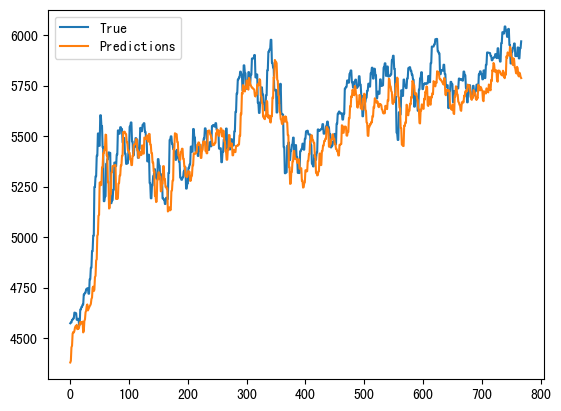

In [181]:
# 预测
pred_Y = model.predict(test_X).reshape(-1, 1)
test_Y = test_Y.reshape(-1, 1)

# 反缩放预测结果
pred_Y_sc = Scaler.inverse_transform(np.concatenate((pred_Y, np.zeros((len(pred_Y), FEATURES - 1))), axis=1))[:, 0]
test_Y_sc = Scaler.inverse_transform(np.concatenate((test_Y, np.zeros((len(test_Y), FEATURES - 1))), axis=1))[:, 0]

# 计算预测误差
mse = np.mean((pred_Y_sc - test_Y_sc) ** 2)
mape = np.mean(np.abs((test_Y_sc - pred_Y_sc) / test_Y_sc)) * 100

# 可视化预测结果
plt.plot(test_Y_sc, label='True')
plt.plot(pred_Y_sc, label='Predictions')
plt.legend()

In [182]:
mse, mape

(20017.48573156535, 2.0007921509068134)

## 循环预测

In [183]:
# 预测的后FORECAST_STEPS价格
y_hat = Scaler.inverse_transform(np.concatenate((pred_Y, np.zeros((len(pred_Y), FEATURES - 1))), axis=1))[:, 0].reshape(-1, FORECAST_STEPS)
y_hat

array([[4380.90749338, 4389.07040973],
       [4455.6170935 , 4463.5978955 ],
       [4523.62710684, 4531.37932715],
       [4529.05689968, 4536.80004557],
       [4553.00071377, 4560.56268402],
       [4559.60408034, 4567.14602427],
       [4545.52776677, 4553.17750863],
       [4547.38176605, 4555.00553629],
       [4573.74235035, 4581.24580619],
       [4572.15808057, 4579.70690856],
       [4575.75390046, 4582.95680503],
       [4529.5389395 , 4537.30086006],
       [4586.40367915, 4593.8337573 ],
       [4629.13374727, 4636.31193185],
       [4660.90394163, 4667.83961998],
       [4638.34882777, 4645.40122202],
       [4652.19655966, 4659.3276511 ],
       [4663.84092683, 4670.89081779],
       [4694.95963992, 4701.76405199],
       [4749.79139504, 4756.21483763],
       [4733.98343048, 4740.53579252],
       [4803.62433737, 4809.75082716],
       [4885.58675141, 4891.02014274],
       [5008.89929487, 5013.16208513],
       [5107.12761911, 5110.6486532 ],
       [5270.65129495, 52

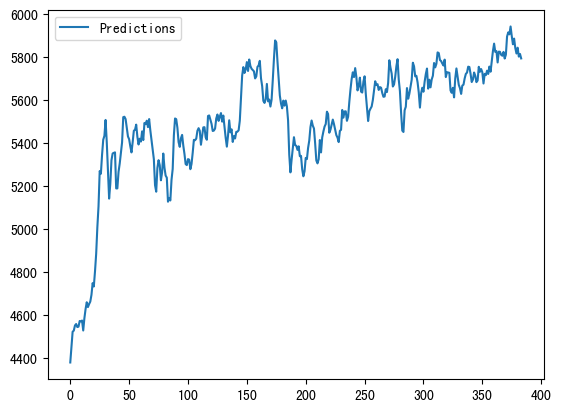

In [184]:
# 可视化预测结果
plt.plot(y_hat[:, 0], label='Predictions')
plt.legend()

In [185]:

def predict_stock_price():
    # input_data = test_X[0]  # 获取测试集最后一个时间步的数据作为起始点
    predictions = np.empty((1, 1))  # 存储预测结果
    j = 0

    # 循环预测
    for i in range(len(test_X)):
        # 将输入数据重塑为LSTM模型所需的形状
        input_data = test_X[j].reshape(1, TIME_STEPS, FEATURES)  # 测试集中第一条数据

        # 使用LSTM模型进行预测
        pred_y = model.predict(input_data).reshape(-1, 1)
        print(j, pred_y)

        # 将预测结果添加到预测列表中
        predictions = np.concatenate((predictions, pred_y), axis=0)

        # 观测期
        j += FORECAST_STEPS

        if j >= len(test_X):
            break

    # 对预测结果进行反归一化处理
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = Scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), FEATURES - 1))), axis=1))[:, 0]

    return predictions

# y_hat = predict_stock_price()
# y_hat

In [186]:
# 可视化预测结果
# plt.plot(test_Y_sc.reshape(-1, 5)[:, 0], label='True')
# plt.plot(y_hat, label='Predictions')
# plt.legend()

In [187]:
# y_hat.shape, test_Y_sc.reshape(-1, 5)[:, 0].shape

## 投资策略

In [188]:
y_hat

array([[4380.90749338, 4389.07040973],
       [4455.6170935 , 4463.5978955 ],
       [4523.62710684, 4531.37932715],
       [4529.05689968, 4536.80004557],
       [4553.00071377, 4560.56268402],
       [4559.60408034, 4567.14602427],
       [4545.52776677, 4553.17750863],
       [4547.38176605, 4555.00553629],
       [4573.74235035, 4581.24580619],
       [4572.15808057, 4579.70690856],
       [4575.75390046, 4582.95680503],
       [4529.5389395 , 4537.30086006],
       [4586.40367915, 4593.8337573 ],
       [4629.13374727, 4636.31193185],
       [4660.90394163, 4667.83961998],
       [4638.34882777, 4645.40122202],
       [4652.19655966, 4659.3276511 ],
       [4663.84092683, 4670.89081779],
       [4694.95963992, 4701.76405199],
       [4749.79139504, 4756.21483763],
       [4733.98343048, 4740.53579252],
       [4803.62433737, 4809.75082716],
       [4885.58675141, 4891.02014274],
       [5008.89929487, 5013.16208513],
       [5107.12761911, 5110.6486532 ],
       [5270.65129495, 52

In [189]:
y_real = Scaler.inverse_transform(np.concatenate((test_Y, np.zeros((len(test_Y), FEATURES - 1))), axis=1))[:, 0]
y_real = y_real.reshape(-1, FORECAST_STEPS)
y_real

array([[4574.8764, 4578.8989],
       [4578.8989, 4591.9647],
       [4591.9647, 4598.6915],
       [4598.6915, 4627.4363],
       [4627.4363, 4624.6669],
       [4624.6669, 4592.138 ],
       [4592.138 , 4596.9649],
       [4596.9649, 4566.5181],
       [4566.5181, 4643.2158],
       [4643.2158, 4655.9279],
       [4655.9279, 4667.5844],
       [4667.5844, 4717.905 ],
       [4717.905 , 4725.9377],
       [4725.9377, 4743.4515],
       [4743.4515, 4748.3341],
       [4748.3341, 4721.121 ],
       [4721.121 , 4792.7106],
       [4792.7106, 4849.456 ],
       [4849.456 , 4931.0958],
       [4931.0958, 5008.3497],
       [5008.3497, 5249.302 ],
       [5249.302 , 5301.9402],
       [5301.9402, 5403.7472],
       [5403.7472, 5513.8979],
       [5513.8979, 5452.8487],
       [5452.8487, 5604.0072],
       [5604.0072, 5550.2048],
       [5550.2048, 5445.8282],
       [5445.8282, 5178.8501],
       [5178.8501, 5202.8155],
       [5202.8155, 5362.6629],
       [5362.6629, 5385.9746],
       [

In [190]:
df_portfolio = pd.DataFrame(np.concatenate((y_hat, y_real), axis=1))

# 计算回报
df_portfolio['return_hat'] = (df_portfolio[FORECAST_STEPS - 1] - df_portfolio[0]) / df_portfolio[0] * 100
df_portfolio['return_real'] = (df_portfolio[FORECAST_STEPS * 2 - 1] - df_portfolio[FORECAST_STEPS]) / df_portfolio[
    FORECAST_STEPS] * 100

#隔行保留
df_portfolio = df_portfolio[0::FORECAST_STEPS]

# 检查 col1 和 col2 是否具有相同的符号
df_portfolio['sign_match'] = (df_portfolio['return_real'] * df_portfolio['return_hat']) > 0
df_portfolio['return_flag_hat'] = df_portfolio['return_hat'].apply(lambda x: 1 if x > 0 else -1)
df_portfolio['return_flag_real'] = df_portfolio['return_real'].apply(lambda x: 1 if x > 0 else -1)

# 决策变量
df_portfolio['investor_return'] = df_portfolio['return_flag_hat'] * df_portfolio['return_real']
# 计算累积市值
df_portfolio['investor_mv'] = ((df_portfolio['investor_return'] + 100) / 100).cumprod(axis=0)

# 计算基准组累积市值
df_portfolio['base_mv'] = ((df_portfolio['return_real'] + 100) / 100).cumprod(axis=0)

# 统计 sign_match 中 True 的百分比
percent_true = df_portfolio['sign_match'].mean() * 100
print(percent_true)

df_portfolio


49.47916666666667


,0,1,2,3,return_hat,return_real,sign_match,return_flag_hat,return_flag_real,investor_return,investor_mv,base_mv
0,4380.907493,4389.070410,4574.8764,4578.8989,0.186329,0.087926,True,1,1,0.087926,1.000879,1.000879
2,4523.627107,4531.379327,4591.9647,4598.6915,0.171372,0.146491,True,1,1,0.146491,1.002345,1.002345
4,4553.000714,4560.562684,4627.4363,4624.6669,0.166088,-0.059847,False,1,-1,-0.059847,1.001746,1.001746
6,4545.527767,4553.177509,4592.1380,4596.9649,0.168292,0.105112,True,1,1,0.105112,1.002799,1.002799
8,4573.742350,4581.245806,4566.5181,4643.2158,0.164055,1.679566,True,1,1,1.679566,1.019641,1.019641
...,...,...,...,...,...,...,...,...,...,...,...,...
374,5942.453960,5933.842016,5951.2860,5860.2669,-0.144922,-1.529402,True,-1,-1,1.529402,1.046345,1.156723
376,5859.594117,5852.528267,5918.8192,5937.9297,-0.120586,0.322877,False,-1,1,-0.322877,1.042967,1.160457
378,5842.728825,5835.907046,5959.1574,5896.6385,-0.116757,-1.049123,True,-1,-1,1.049123,1.053909,1.148283
380,5843.767377,5836.900852,5897.1579,5939.4153,-0.117502,0.716572,False,-1,1,-0.716572,1.046357,1.156511


### 可视化投资策略

In [191]:
df_portfolio=pd.read_csv('outputs/sentindex_lstm.csv')

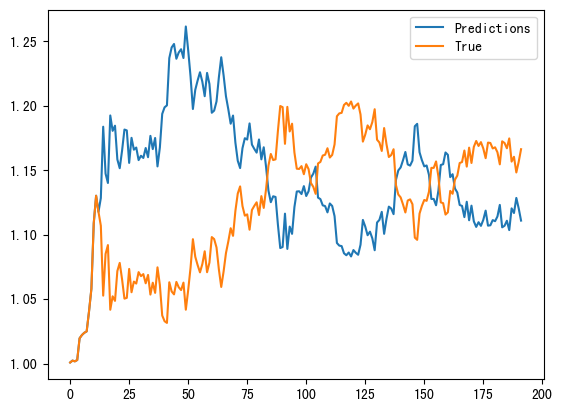

In [192]:
plt.plot(df_portfolio[['investor_mv']], label='Predictions')
plt.plot(df_portfolio[['base_mv']], label='True')
plt.legend()